# Rossi Data Model Bakeoff
This notebook uses the surv_nn environment


In [21]:
import torch
import numpy as np
import torchtuples as tt 
import matplotlib.pyplot as plt

import seaborn as sns
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler

from lifelines.datasets import load_rossi
from sklearn.model_selection import train_test_split
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [22]:
df = load_rossi()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   week    432 non-null    int64
 1   arrest  432 non-null    int64
 2   fin     432 non-null    int64
 3   age     432 non-null    int64
 4   race    432 non-null    int64
 5   wexp    432 non-null    int64
 6   mar     432 non-null    int64
 7   paro    432 non-null    int64
 8   prio    432 non-null    int64
dtypes: int64(9)
memory usage: 30.5 KB


In [24]:
df.describe()

,week,arrest,fin,age,race,wexp,mar,paro,prio
count,432.000000,432.000000,432.00000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,45.854167,0.263889,0.50000,24.597222,0.877315,0.571759,0.122685,0.618056,2.983796
std,12.662293,0.441251,0.50058,6.113375,0.328456,0.495398,0.328456,0.486426,2.896068
min,1.000000,0.000000,0.00000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,0.00000,20.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,52.000000,0.000000,0.50000,23.000000,1.000000,1.000000,0.000000,1.000000,2.000000
75%,52.000000,1.000000,1.00000,27.000000,1.000000,1.000000,0.000000,1.000000,4.000000
max,52.000000,1.000000,1.00000,44.000000,1.000000,1.000000,1.000000,1.000000,18.000000


In [25]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [26]:
cph = CoxPHFitter().fit(train, 'week', 'arrest')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 302 total observations, 226 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 302
number of events observed = 76
   partial log-likelihood = -410.52
         time fit was run = 2022-10-17 02:38:27 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.61       0.54       0.24            -1.08            -0.14                 0.34                 0.87
age        -0.05       0.95       0.03            -0.10             0.00                 0.90                 1.00
race        0.27       1.32       0.36            -0.43             0.98                 0.65                 2.67
wexp        0.08       1.08       0.25            -0.42             0.58                 0.66                 1.78
mar        -0.68       0.51       0.48            -1.62             0.27                 0.20                 1.30
paro       -0.13       0.88       0.24            -0.59             0.34                 0.55                 1.40
prio        0.11       1.12       0.03             0.04             0.18                 1.04                 1.20

            cmp to     z      p   -log2(p)
covariate                                 
fin           0.00 -2.54   0.01       6.50
age           0.00 -1.91   0.06       4.17
race          0.00  0.76   0.45       1.16
wexp          0.00  0.31   0.76       0.40
mar           0.00 -1.41   0.16       2.65
paro          0.00 -0.53   0.59       0.75
prio          0.00  3.20 <0.005       9.52
---
Concordance = 0.66
Partial AIC = 835.05
log-likelihood ratio test = 26.26 on 7 df
-log2(p) of ll-ratio test = 11.11

In [27]:
cph.score(test, scoring_method = "concordance_index")

0.5714626580768313

In [28]:
cols_standardize = ['age', 'prio']
cols_other = ['fin', 'race', 'wexp', 'mar', 'paro']
standardize = [([col], StandardScaler()) for col in cols_standardize]
for row, scaler in standardize:
    train[row] = scaler.fit_transform(train[row])
    test[row] = scaler.transform(test[row])

In [29]:
xtrain = train[cols_standardize + cols_other].astype('float32').to_numpy()
xtest = test[cols_standardize + cols_other].astype('float32').to_numpy()

In [30]:
num_durations = 2

labtrans = LogisticHazard.label_transform(num_durations)

get_target = lambda df: (df['week'].values, df['arrest'].values)

ytrain = labtrans.fit_transform(*get_target(train))
ytest = labtrans.transform(*get_target(test))

train_post = (xtrain, ytrain)
test_post = (xtest, ytest)

In [31]:
in_features = xtrain.shape[1]
lin_nodes = 8
num_nodes = [lin_nodes, lin_nodes]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, lin_nodes),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(lin_nodes),
     torch.nn.Dropout(0.1),
    
     torch.nn.Linear(lin_nodes, lin_nodes),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(lin_nodes),
     torch.nn.Dropout(0.1),
   
     torch.nn.Linear(lin_nodes, out_features)
)

In [32]:
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [33]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)


In [34]:
batch_size = 16 #256
epochs = 100
callbacks = [tt.cb.EarlyStopping(patience = 3)]

In [35]:
log = model.fit(xtrain, ytrain, batch_size, epochs, callbacks, val_data = test_post) # , callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 1.4150,	val_loss: 1.2536
1:	[0s / 0s],		train_loss: 1.0544,	val_loss: 0.9385
2:	[0s / 0s],		train_loss: 0.7533,	val_loss: 0.7205
3:	[0s / 0s],		train_loss: 0.5981,	val_loss: 0.6614
4:	[0s / 0s],		train_loss: 0.5729,	val_loss: 0.6408
5:	[0s / 0s],		train_loss: 0.5462,	val_loss: 0.6249
6:	[0s / 0s],		train_loss: 0.5496,	val_loss: 0.6310
7:	[0s / 0s],		train_loss: 0.5415,	val_loss: 0.6222
8:	[0s / 0s],		train_loss: 0.5647,	val_loss: 0.6336
9:	[0s / 0s],		train_loss: 0.5489,	val_loss: 0.6254
10:	[0s / 0s],		train_loss: 0.5431,	val_loss: 0.6209
11:	[0s / 0s],		train_loss: 0.5477,	val_loss: 0.6258
12:	[0s / 0s],		train_loss: 0.5429,	val_loss: 0.6370
13:	[0s / 0s],		train_loss: 0.5356,	val_loss: 0.6452


<AxesSubplot:>

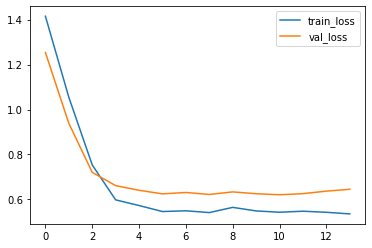

In [36]:
log.plot()

In [37]:
durations_test, events_test = get_target(test)

In [41]:
surv = model.interpolate(10).predict_surv_df(xtest)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
ev.concordance_td('antolini')

0.5368647100930566

In [39]:
#tt.cb.EarlyStopping?